# Merging Fire, Climate and Land Data

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

pd.options.display.float_format = "{:,.2f}".format

## Fire data

In [33]:
file_path = '../data/fire3.csv'
fire_df = pd.read_csv(file_path)
fire_df 
fire_df['time'] = pd.to_datetime(fire_df['time'])
fire_df['year'] = fire_df['time'].dt.year
fire_df['month'] = fire_df['time'].dt.month
fire_df['day'] = fire_df['time'].dt.day
fire_df = fire_df.reindex(columns=['lon_bounds', 'lat_bounds', 'time', 'year', 'month', 'day', 'burned_area', 'fraction_of_burnable_area', 'CL'])
fire_df = fire_df.drop_duplicates(subset=['lon_bounds', 'lat_bounds', 'year', 'month', 'day'])
fire_df = fire_df.sort_values(['lon_bounds','lat_bounds','year','month', 'day'])
fire_df['month'] = fire_df['month'] - fire_df['day'].map(lambda x: 1 if x <= 15 else 0)
fire_df['year'] = fire_df['year'] - fire_df['month'].map(lambda x: 1 if x == 0 else 0)
fire_df['month'] = fire_df['month'].map(lambda x: 12 if x == 0 else x)
fire_df = fire_df[fire_df['year'] != 2000]
fire_df.rename(columns={'lat_bounds': 'lat', 'lon_bounds': 'lon', 'fraction_of_burnable_area': 'burnable_frac'}, inplace=True)
fire_df.reset_index(inplace=True)
fire_df = fire_df.drop(['index','time','day','CL'], axis=1)
fire_df = fire_df[(fire_df['burned_area']<=50*10**6)]
fire_df = fire_df[fire_df['burnable_frac']>=0.9]
fire_df

,lon,lat,year,month,burned_area,burnable_frac
1362,-9.75,52.00,2001,1,0.00,0.94
1363,-9.75,52.00,2001,2,0.00,0.94
1364,-9.75,52.00,2001,3,0.00,0.94
1365,-9.75,52.00,2001,4,0.00,0.94
1366,-9.75,52.00,2001,5,0.00,0.94
...,...,...,...,...,...,...
3140216,50.00,51.75,2019,7,0.00,0.99
3140217,50.00,51.75,2019,8,0.00,0.99
3140218,50.00,51.75,2019,9,0.00,0.99
3140219,50.00,51.75,2019,10,0.00,0.99


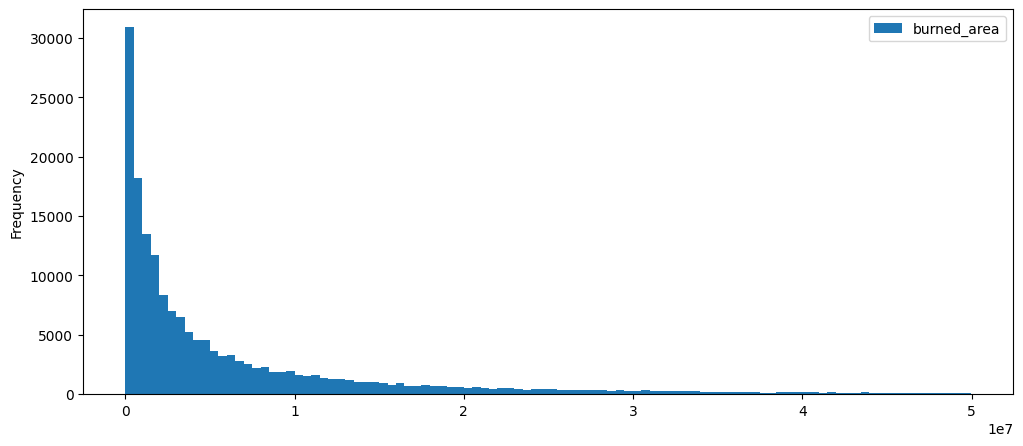

In [34]:
fire_df[(fire_df['burned_area']<=1*10**8) & (fire_df['burned_area']>0)].plot.hist(column=["burned_area"], bins=100, figsize=(12, 5));

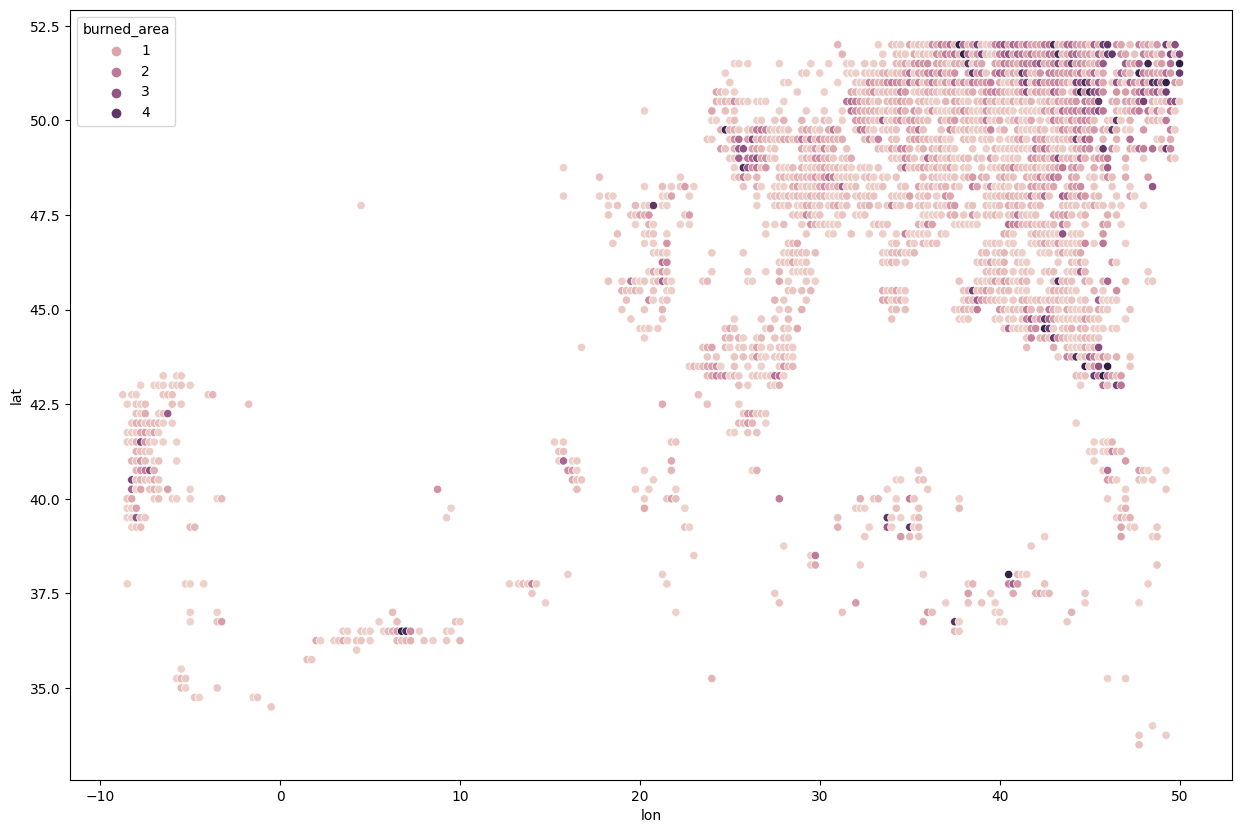

In [35]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=fire_df[(fire_df['burned_area']<=1*10**8) & (fire_df['burned_area']>0) & (fire_df['year']==2005) & (fire_df['burned_area']>0) & (fire_df['month']==8)], x='lon', y='lat', hue = 'burned_area');

## Climate data

In [36]:
climate_df = pd.read_csv('../data/climate.csv')
climate_df = climate_df.drop(['Unnamed: 0'], axis=1)
climate_df

,lon,lat,year,month,temperature,precipitation,temperature1,precipitation1,temperature2,precipitation2,temperature3,precipitation3,temperature4,precipitation4
0,-10.00,33.00,2001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-10.00,33.00,2001,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-10.00,33.00,2001,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-10.00,33.00,2001,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-10.00,33.00,2001,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4230991,50.00,52.00,2019,8,19.60,30.20,22.40,40.50,22.40,22.80,18.80,29.50,8.90,19.20
4230992,50.00,52.00,2019,9,12.90,25.50,19.60,30.20,22.40,40.50,22.40,22.80,18.80,29.50
4230993,50.00,52.00,2019,10,9.50,24.20,12.90,25.50,19.60,30.20,22.40,40.50,22.40,22.80
4230994,50.00,52.00,2019,11,-2.60,12.20,9.50,24.20,12.90,25.50,19.60,30.20,22.40,40.50


In [37]:
drydays_df = pd.read_csv('../data/drydays.csv')
drydays_df = drydays_df.drop(['Unnamed: 0'], axis=1)
drydays_df = drydays_df.sort_values(['lon','lat','year'])
drydays_df = drydays_df.reset_index()
drydays_df = drydays_df.drop(['index'], axis=1)
drydays_df = drydays_df.reindex(columns=['lon', 'lat', 'year', 'dry_days'])
drydays_df

,lon,lat,year,dry_days
0,-10.00,33.00,2001,36.72
1,-10.00,33.00,2002,56.70
2,-10.00,33.00,2003,38.99
3,-10.00,33.00,2004,62.34
4,-10.00,33.00,2005,43.05
...,...,...,...,...
296907,50.00,52.00,2012,27.88
296908,50.00,52.00,2013,24.84
296909,50.00,52.00,2014,39.60
296910,50.00,52.00,2015,31.66


## Land data

In [38]:
land_df = pd.read_csv('../data/satellite_landcover_dataset.csv')
#land_df = land_df.drop(['Unnamed: 0'], axis=1)
#land_df = land_df.rename(columns={"lon": "lon_bounds", "lat": "lat_bounds"})
land_df = land_df.drop(['lat_bounds', 'lon_bounds'], axis=1)
land_df.rename(columns={'time': 'year', 'lccs_class': 'land_cover'}, inplace=True)
land_df = land_df.reindex(columns=['lon', 'lat', 'year', 'land_cover', 'processed_flag', 'current_pixel_state', 'observation_count', 'change_count'])
land_df = land_df.sort_values(['lon','lat','year'])
land_df = land_df.drop(['processed_flag', 'current_pixel_state', 'observation_count', 'change_count'], axis=1)
land_df = land_df[land_df['year'] != 2020]
land_df = land_df.drop_duplicates()
land_df.reset_index(inplace=True)
land_df = land_df.drop(['index'], axis=1)
land_df

,lon,lat,year,land_cover
0,-10.00,33.00,2001,210
1,-10.00,33.00,2002,210
2,-10.00,33.00,2003,210
3,-10.00,33.00,2004,210
4,-10.00,33.00,2005,210
...,...,...,...,...
352578,50.00,52.00,2015,10
352579,50.00,52.00,2016,10
352580,50.00,52.00,2017,10
352581,50.00,52.00,2018,10


In [39]:
country_df = pd.read_csv('../data/country_all.csv')
country_df = country_df.drop(['Unnamed: 0'], axis=1)
country_df = country_df.sort_values(['lon','lat'])
country_df = country_df.reset_index()
country_df = country_df.drop(['index'], axis=1)
country_df

,lat,lon,country
0,51.50,-10.00,Éire / Ireland
1,51.75,-10.00,Éire / Ireland
2,52.00,-10.00,Éire / Ireland
3,38.75,-9.75,Portugal
4,39.00,-9.75,Portugal
...,...,...,...
13994,51.00,50.00,Қазақстан
13995,51.25,50.00,Россия
13996,51.50,50.00,Россия
13997,51.75,50.00,Россия


## Merging data

In [40]:
merge_1_df = fire_df.merge(
    climate_df,
    how='left',
    on=['lat', 'lon', 'year', 'month']
    )

merge_2_df = merge_1_df.merge(
    drydays_df,
    how='left',
    on=['lat', 'lon', 'year']
    )

merge_3_df = merge_2_df.merge(
    land_df,
    how='left',
    on=['lat', 'lon', 'year']
    )

all_df = merge_3_df.merge(
    country_df,
    how='left',
    on=['lat', 'lon']
    )

all_df = all_df.sort_values(['lat', 'lon','year'])

all_df

,lon,lat,year,month,burned_area,burnable_frac,temperature,precipitation,temperature1,precipitation1,temperature2,precipitation2,temperature3,precipitation3,temperature4,precipitation4,dry_days,land_cover,country
8972,-8.25,33.00,2001,1,0.00,0.98,13.50,48.70,14.70,105.20,15.90,20.00,18.80,31.90,23.10,7.80,119.68,11,Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب
8973,-8.25,33.00,2001,2,0.00,0.98,14.20,8.90,13.50,48.70,14.70,105.20,15.90,20.00,18.80,31.90,119.68,11,Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب
8974,-8.25,33.00,2001,3,0.00,0.98,17.20,25.30,14.20,8.90,13.50,48.70,14.70,105.20,15.90,20.00,119.68,11,Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب
8975,-8.25,33.00,2001,4,0.00,0.98,18.00,1.80,17.20,25.30,14.20,8.90,13.50,48.70,14.70,105.20,119.68,11,Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب
8976,-8.25,33.00,2001,5,0.00,0.98,19.20,9.30,18.00,1.80,17.20,25.30,14.20,8.90,13.50,48.70,119.68,11,Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189684,49.75,52.00,2019,7,0.00,0.99,22.40,40.50,22.40,22.80,18.80,29.50,8.90,19.20,0.00,52.00,NaN,11,Россия
2189685,49.75,52.00,2019,8,0.00,0.99,19.60,30.20,22.40,40.50,22.40,22.80,18.80,29.50,8.90,19.20,NaN,11,Россия
2189686,49.75,52.00,2019,9,0.00,0.99,12.90,25.50,19.60,30.20,22.40,40.50,22.40,22.80,18.80,29.50,NaN,11,Россия
2189687,49.75,52.00,2019,10,0.00,0.99,9.50,24.20,12.90,25.50,19.60,30.20,22.40,40.50,22.40,22.80,NaN,11,Россия


In [41]:
v = all_df['country'].value_counts()
all_df = all_df[all_df['country'].isin(v.index[v.gt(1000)])]
all_df['country'].unique().shape

(42,)

In [42]:
v2 = all_df['land_cover'].value_counts()
all_df = all_df[all_df['land_cover'].isin(v2.index[v2.gt(1000)])]
all_df['land_cover'].unique().shape

(22,)

In [43]:
all_df['burned_area'] = all_df['burned_area'].apply(lambda x: 0 if x == 0 else 1)
all_df.reset_index(inplace=True)
all_df = all_df.drop(['index'], axis=1)
all_df

,lon,lat,year,month,burned_area,burnable_frac,temperature,precipitation,temperature1,precipitation1,temperature2,precipitation2,temperature3,precipitation3,temperature4,precipitation4,dry_days,land_cover,country
0,-8.25,33.00,2001,1,0,0.98,13.50,48.70,14.70,105.20,15.90,20.00,18.80,31.90,23.10,7.80,119.68,11,Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب
1,-8.25,33.00,2001,2,0,0.98,14.20,8.90,13.50,48.70,14.70,105.20,15.90,20.00,18.80,31.90,119.68,11,Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب
2,-8.25,33.00,2001,3,0,0.98,17.20,25.30,14.20,8.90,13.50,48.70,14.70,105.20,15.90,20.00,119.68,11,Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب
3,-8.25,33.00,2001,4,0,0.98,18.00,1.80,17.20,25.30,14.20,8.90,13.50,48.70,14.70,105.20,119.68,11,Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب
4,-8.25,33.00,2001,5,0,0.98,19.20,9.30,18.00,1.80,17.20,25.30,14.20,8.90,13.50,48.70,119.68,11,Maroc / ⵍⵎⵖⵔⵉⴱ / المغرب
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192042,49.75,52.00,2019,7,0,0.99,22.40,40.50,22.40,22.80,18.80,29.50,8.90,19.20,0.00,52.00,NaN,11,Россия
2192043,49.75,52.00,2019,8,0,0.99,19.60,30.20,22.40,40.50,22.40,22.80,18.80,29.50,8.90,19.20,NaN,11,Россия
2192044,49.75,52.00,2019,9,0,0.99,12.90,25.50,19.60,30.20,22.40,40.50,22.40,22.80,18.80,29.50,NaN,11,Россия
2192045,49.75,52.00,2019,10,0,0.99,9.50,24.20,12.90,25.50,19.60,30.20,22.40,40.50,22.40,22.80,NaN,11,Россия


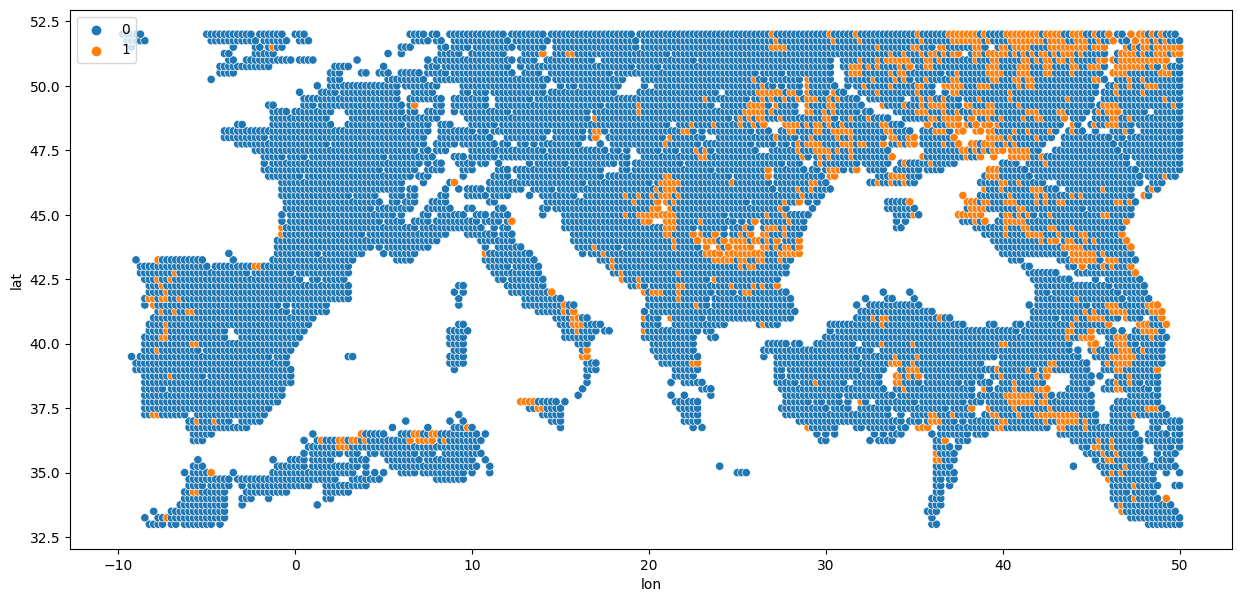

In [44]:
year = 2018
month = 8
merged_df_plotting = all_df[(all_df['year'] == year) & (all_df['month'] == month)]

plt.figure(figsize=(15,7))
sns.scatterplot(data=merged_df_plotting, x='lon', y='lat', hue = 'burned_area')
plt.legend(loc='upper left');

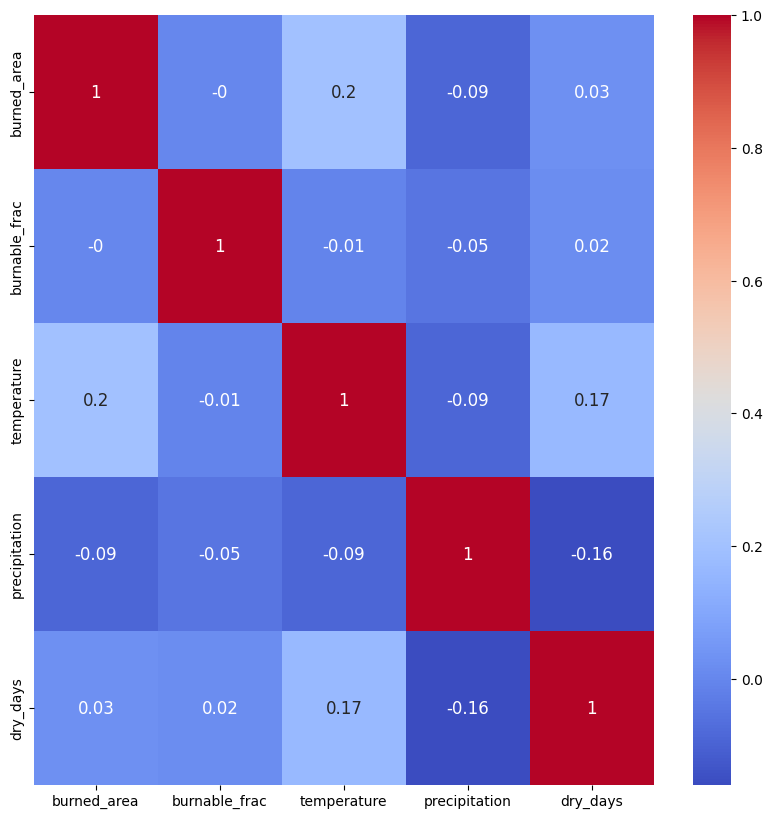

In [45]:
plt.figure(figsize = (10,10))
frame = all_df[['burned_area', 'burnable_frac', 'temperature', 'precipitation', 'dry_days']]
sns.heatmap(round(frame.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12});

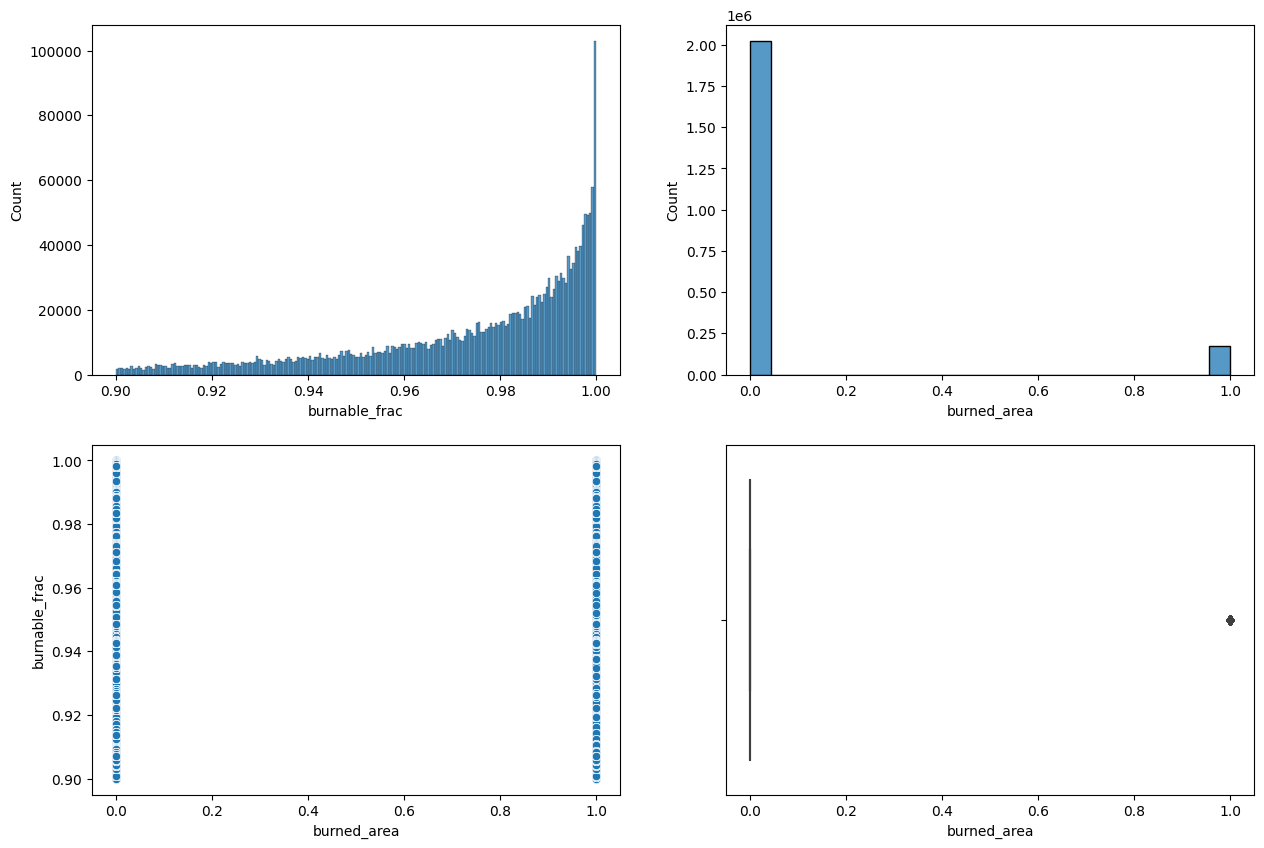

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(all_df['burnable_frac'], ax=ax1)
sns.histplot(all_df['burned_area'], ax=ax2)
sns.scatterplot(data=all_df, x='burned_area', y='burnable_frac', ax=ax3)
sns.boxplot(data = all_df, x= 'burned_area', ax=ax4)
plt.show();

In [47]:
all_df.to_csv('../data/all_merged.csv')